In [1]:
import pandas as pd
import numpy as np
import scipy
import random
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from models import *
from utils import *

# Funções auxiliares

In [2]:
def histograma_distribuicao(coluna, titulo, feature, funcao):
    dist_params = funcao.fit(coluna)
    dist = funcao(*dist_params)
    x = np.linspace(0, 1, 200)
    fig, ax = plt.subplots(1,2)
    plt.title(feature + ' - ' + titulo + ' distribution')
    sns.histplot(x=coluna, ax=ax[1], color='green')
    sns.lineplot(x=coluna, y=dist.pdf(coluna), ax=ax[0],color='black')
    plt.show()

def augment_dataset(X, y,quantity=300,dists = [], dists_method = []):
    if dists == []:
        dists = [scipy.stats.norm] * X.shape[1]
    if dists_method == []:
        dists_method = [scipy.stats.norm] * X.shape[1]
    classes = y.unique()
    contador_x = X.shape[0]
    contador_y = len(y)
    for cls in classes:
        index = np.where(y == cls) 
        class_samples = X.loc[index]
        for cs in range(quantity - class_samples.shape[0]):
            new_sample = []
            for f_index, feature in enumerate(X.columns):
                dist = dists[f_index]
                distr_params = dist.fit(class_samples[feature])
                new_distr = dist(*distr_params)
                dist_method = dists_method[f_index]
                distr_params_method = dist_method.fit(class_samples[feature])
                new_distr_method = dist_method(*distr_params_method)
                while True:
                    rand_value = random.randint(0, 100) / 100
                    new_sample_attribute = random.randint(0, 100) / 100
                    if new_distr_method.pdf(new_sample_attribute) * rand_value < new_distr.pdf(new_sample_attribute):
                        new_sample.append(new_sample_attribute)
                        break
            X.loc[contador_x] = new_sample
            contador_x += 1
            y.loc[contador_y] = cls
            contador_y +=1
    return X, y
def make_plot(classifier,title,data,data_labels,labels):
    step = .02
    cmap_base = ListedColormap(['lightcoral', 'cornflowerblue', 'bisque'])
    #cmap_labels = ['lightblue', 'gray', 'green']
    cmap_labels = ['red', 'blue', 'orange']

    #Find Minimum and Maximum value for the data
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1

    #Create Grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),np.arange(y_min, y_max, step))

    #Obtain predicted values for each of the grid's points
    Z = np.array(classifier.predict(np.c_[xx.ravel(), yy.ravel()]))
    for i in range(len(np.unique(Z))):
        Z[np.where(Z == np.unique(Z)[i])] = str(i)
    Z = Z.astype(int)
    Z = Z.reshape(xx.shape)

    #Make Contours
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=cmap_base)

    #Create a Scatterplot with the data
    #labels = np.unique(data_labels)
    
    for i in range(len(labels)):
        plt.scatter(data[data_labels == labels[i], 0], data[data_labels == labels[i], 1],
                    facecolor=cmap_labels[i], label=labels[i],alpha=0.6, edgecolor="black")
    
    plt.legend()

    #Set the limits for the variables
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.title(title)

    plt.xlabel('X0')
    plt.ylabel('X1')
    plt.show()

# A - Coluna Vertebral

## A.1) Distribuição

In [3]:
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip
#!unzip vertebral_column_data.zip
columns_name = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis','class']
df = pd.read_csv('./datasets./column_3C.dat', names=columns_name, sep=' ')
display(df)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,DH
1,39.06,10.06,25.02,29.00,114.41,4.56,DH
2,68.83,22.22,50.09,46.61,105.99,-3.53,DH
3,69.30,24.65,44.31,44.64,101.87,11.21,DH
4,49.71,9.65,28.32,40.06,108.17,7.92,DH
...,...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25,NO
306,53.94,20.72,29.22,33.22,114.37,-0.42,NO
307,61.45,22.69,46.17,38.75,125.67,-2.71,NO
308,45.25,8.69,41.58,36.56,118.55,0.21,NO


In [4]:
#X = min_max_normalization(df.drop(df.columns[-1:], axis=1))
X = df.drop(df.columns[-1:], axis=1)
X =(X - X.min())/(X.max() - X.min())
y = df[df.columns[-1]]

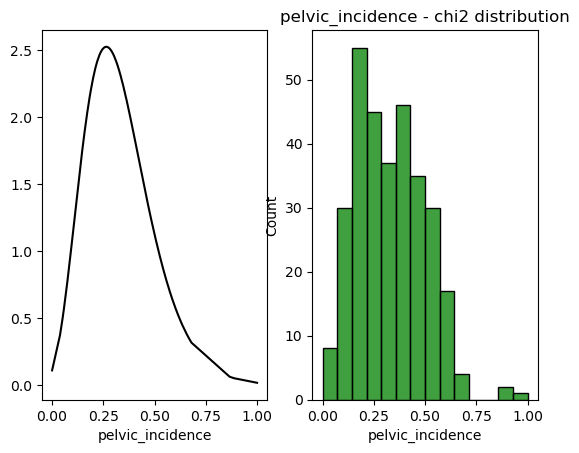

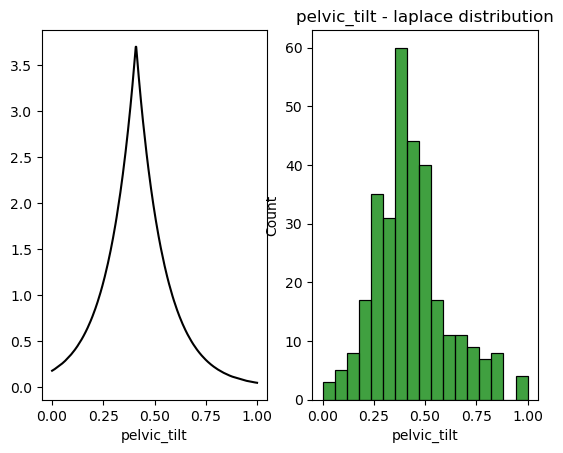

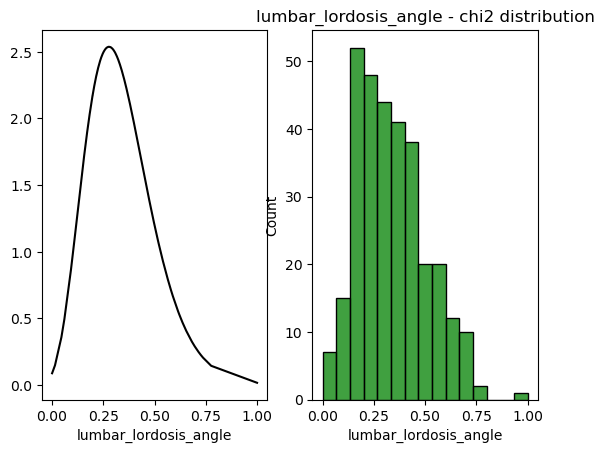

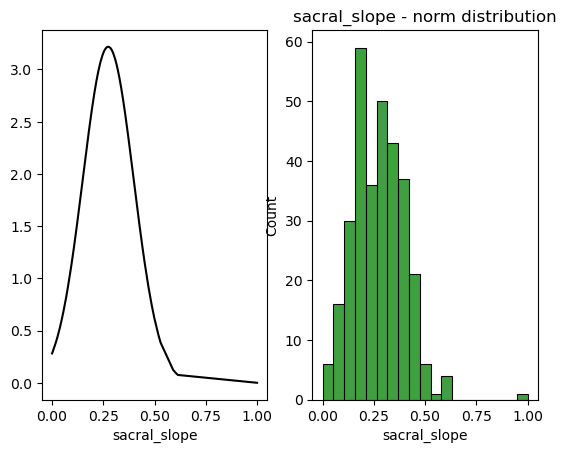

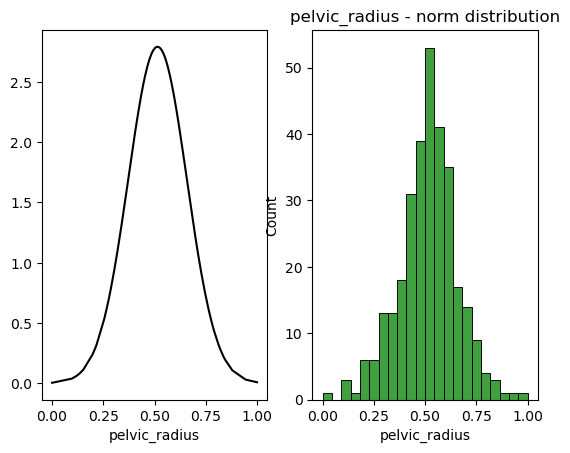

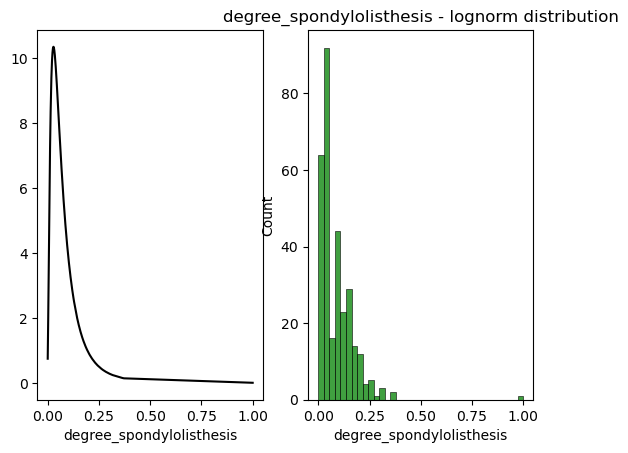

In [5]:
dists = [scipy.stats.chi2, scipy.stats.laplace,scipy.stats.gamma, scipy.stats.norm,scipy.stats.norm,scipy.stats.lognorm]
dists_names = ['chi2','laplace','chi2','norm','norm','lognorm']
for i in range(len(dists)):
    histograma_distribuicao(X[columns_name[i]], dists_names[i],columns_name[i],  dists[i])

## A.2) Naive Bayes

In [6]:
X_bayes = df.iloc[0:, :-1].values
y_bayes = df.iloc[0:, -1].values
X_bayes = np.array(X_bayes)
y_bayes = np.array(y_bayes)

In [7]:
all_accuracies = []
all_cfmats = []
all_predictions = []
all_x_train = []
all_y_train = []
all_x_test = []
all_y_test = []
all_naivebayes = []
for realization in range(20):
    #Separating train and test subsets from original dataset, with 80/20 proportions
    X_train, X_test, y_train, y_test = train_test_split(X_bayes, y_bayes, test_size=0.20)

    #Normalization
    u, s = mean_and_std(X_train)
    X_train = (X_train - u) / s
    X_test = (X_test - u) / s
    all_x_train.append(X_train)
    all_y_train.append(y_train)
    all_x_test.append(X_test)
    all_y_test.append(y_test)

    #Training
    naivebayes = NaiveBayes()
    naivebayes.train(X_train,y_train)
    all_naivebayes.append(naivebayes)

    #Predicting
    predictions = naivebayes.predict(X_test)
    all_predictions.append(predictions)

    #Calculating Accuracy for the n realization and storing it
    accuracy = calc_acc(y_test, predictions)
    all_accuracies.append(accuracy)
    all_cfmats.append(create_cfmat(y_test, predictions))

    #Creating the Confusion Matrix
    cf_matrix = create_cfmat(y_test, predictions)

#Compute the Accuracy (mean of all realization's accuracies) and the standard deviation
mean, std = mean_and_std(all_accuracies)
print("Accuracy mean: ",mean)
print("Accuracy standard deviation",std,'\n')

#Find the realization which it's accuracy is the closest to the mean, i.e, the Accuracy
closest_index = get_closest(mean,all_accuracies)

#Get the X_test, y_test, predicitions, accuracy and trained classifier of the chosen realization
data = all_x_test[closest_index]
data_labels = all_y_test[closest_index]
data_predictions = all_predictions[closest_index]
data_accuracy = all_accuracies[closest_index]
classifier = all_naivebayes[closest_index]

Accuracy mean:  0.8298387096774194
Accuracy standard deviation 0.04687836009462458 



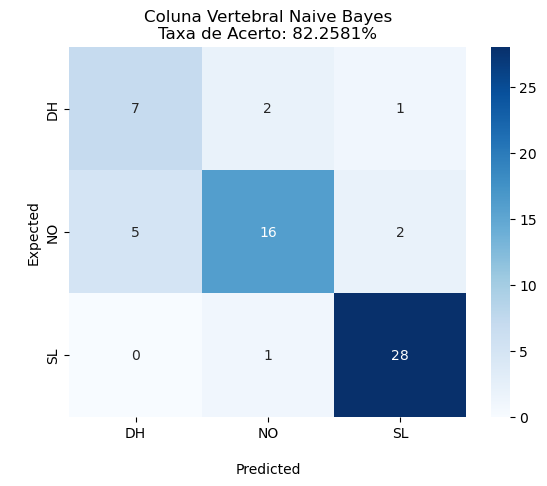

In [8]:
#Generating Confusion Matrix for the realization which it's accuracy is the most similar to the mean
ax = sns.heatmap(all_cfmats[closest_index], annot=True,cmap='Blues',fmt="d")
ax.set_title(f'Coluna Vertebral Naive Bayes\nTaxa de Acerto: {round(data_accuracy,6)*100}%');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('\nExpected');
ax.xaxis.set_ticklabels(np.unique(y))
ax.yaxis.set_ticklabels(np.unique(y))
plt.show()

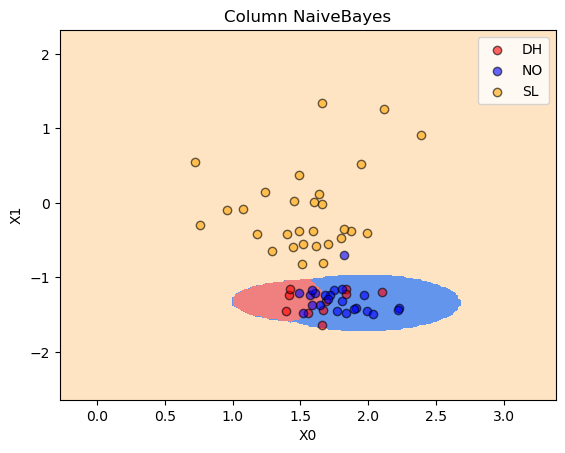

In [9]:
naivebayes_2C = NaiveBayes()
naivebayes_2C.train(all_x_train[-1][:,[4,5]],all_y_train[-1])
make_plot(naivebayes_2C,'Column NaiveBayes',all_x_test[-1][:,[4,5]],all_y_test[-1], np.unique(all_y_test[-1]))

## A.3) Aumentar Conjunto

In [10]:
print(f'X -> {X.shape}, y -> {y.shape}')
X_sampled, y_sampled = augment_dataset(X.copy(), y.copy())

X -> (310, 6), y -> (310,)


n_samples = 900
Classe = DH, DH_samples = 300
Classe = NO, NO_samples = 300
Classe = SL, SL_samples = 300


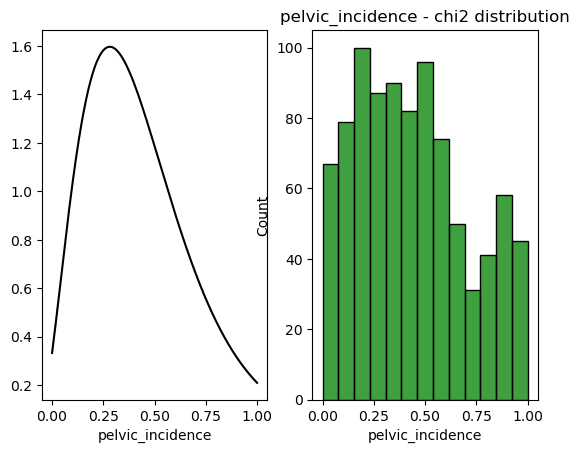

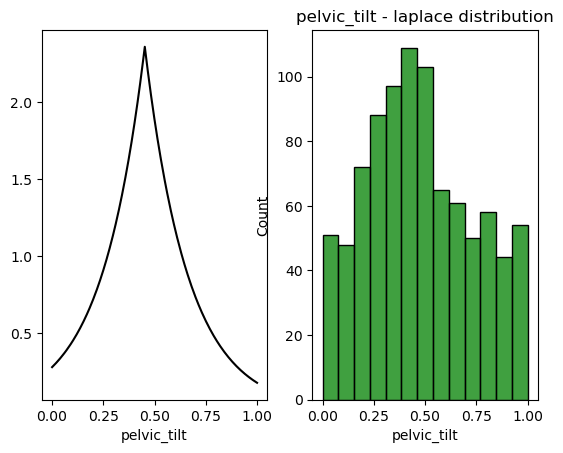

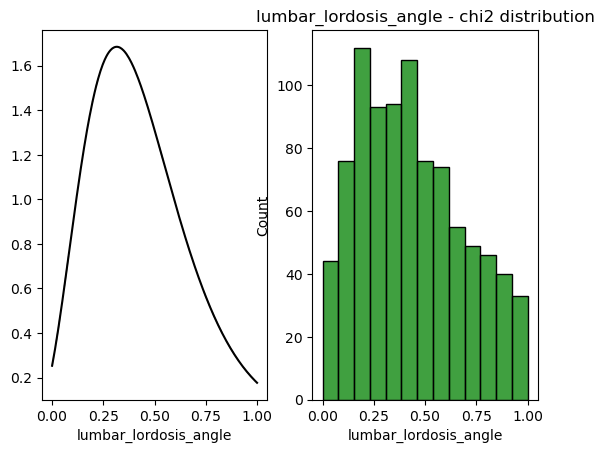

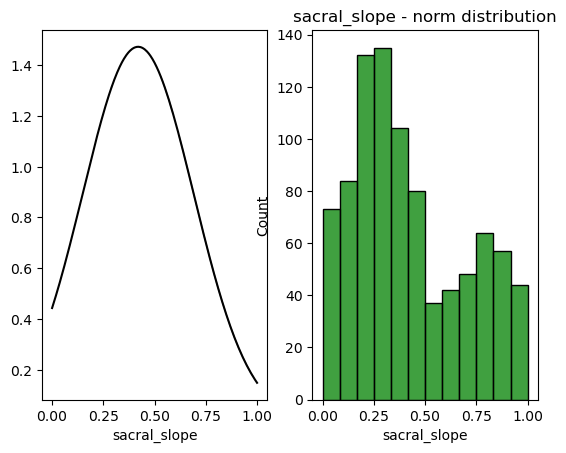

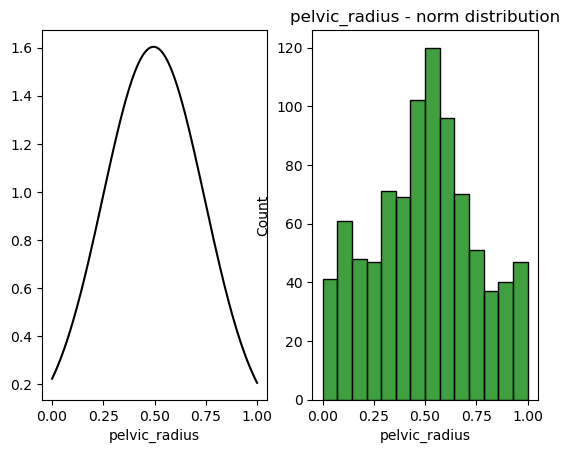

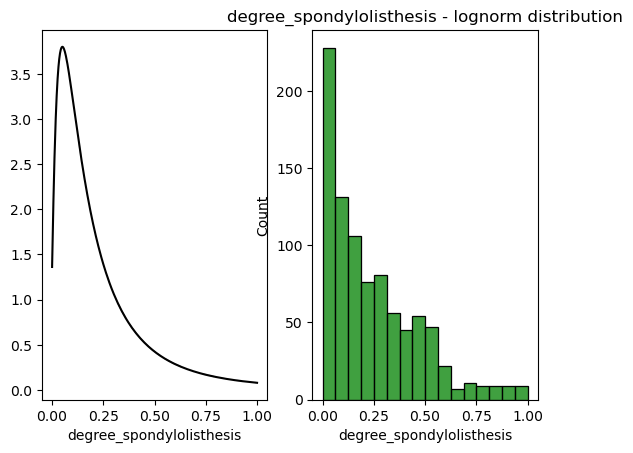

In [11]:
print(f'n_samples = {X_sampled.shape[0]}')
for y_ in np.unique(y_sampled):    
    print(f'Classe = {y_}, {y_}_samples = {len(X_sampled[y_sampled == y_])}')
for i in range(len(dists)):
    histograma_distribuicao(X_sampled[columns_name[i]], dists_names[i],columns_name[i],  dists[i])

# Iris

## A.1) Distribuição

In [12]:
iris_name = ['sepal-length', 	'sepal-width', 	'petal-length', 	'petal-width', 	'class']
iris = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",names = iris_name)

In [13]:
X = iris.drop(['class'], axis=1)
X =(X - X.min())/(X.max() - X.min())
y = iris['class']

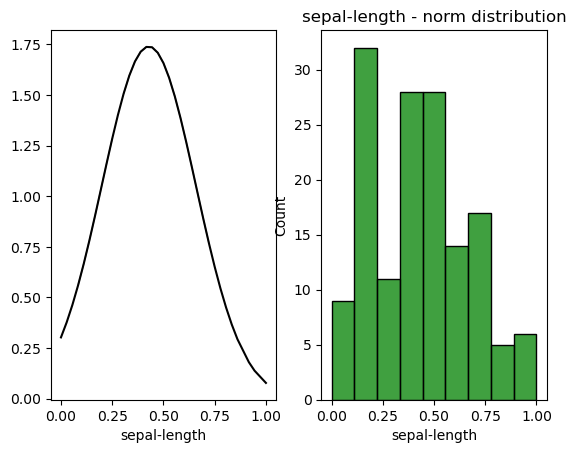

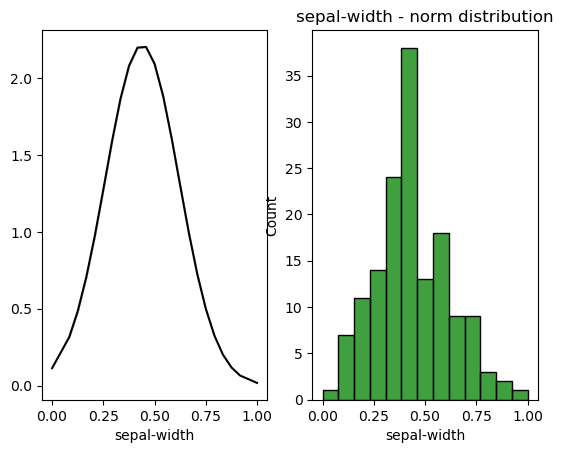

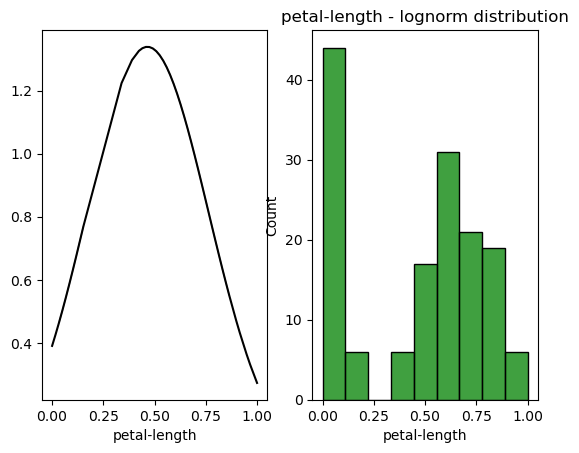

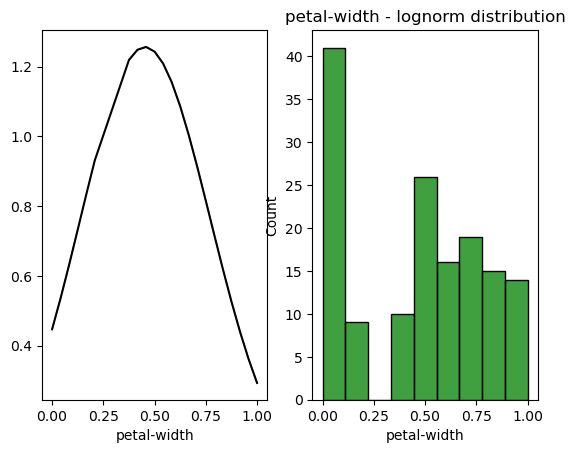

In [14]:
iris_dists = [scipy.stats.norm, scipy.stats.norm, scipy.stats.lognorm, scipy.stats.lognorm]
iris_dists_names = ['norm', 'norm', 'lognorm', 'lognorm']  
for i in range(len(iris_dists)):
    histograma_distribuicao(X[iris_name[i]], iris_dists_names[i], iris_name[i],  iris_dists[i])

## A.2) Naive Bayes

In [15]:
X_bayes = iris.iloc[0:, :-1].values
y_bayes = iris.iloc[0:, -1].values
X_bayes = np.array(X_bayes)
y_bayes = np.array(y_bayes)

In [16]:
all_accuracies = []
all_cfmats = []
all_predictions = []
all_x_train = []
all_y_train = []
all_x_test = []
all_y_test = []
all_naivebayes = []
for realization in range(20):
    #Separating train and test subsets from original dataset, with 80/20 proportions
    X_train, X_test, y_train, y_test = train_test_split(X_bayes, y_bayes, test_size=0.20)

    #Normalization
    u, s = mean_and_std(X_train)
    X_train = (X_train - u) / s
    X_test = (X_test - u) / s
    all_x_train.append(X_train)
    all_y_train.append(y_train)
    all_x_test.append(X_test)
    all_y_test.append(y_test)

    #Training
    naivebayes = NaiveBayes()
    naivebayes.train(X_train,y_train)
    all_naivebayes.append(naivebayes)

    #Predicting
    predictions = naivebayes.predict(X_test)
    all_predictions.append(predictions)

    #Calculating Accuracy for the n realization and storing it
    accuracy = calc_acc(y_test, predictions)
    all_accuracies.append(accuracy)
    all_cfmats.append(create_cfmat(y_test, predictions))

    #Creating the Confusion Matrix
    cf_matrix = create_cfmat(y_test, predictions)

#Compute the Accuracy (mean of all realization's accuracies) and the standard deviation
mean, std = mean_and_std(all_accuracies)
print("Accuracy mean: ",mean)
print("Accuracy standard deviation",std,'\n')

#Find the realization which it's accuracy is the closest to the mean, i.e, the Accuracy
closest_index = get_closest(mean,all_accuracies)

#Get the X_test, y_test, predicitions, accuracy and trained classifier of the chosen realization
data = all_x_test[closest_index]
data_labels = all_y_test[closest_index]
data_predictions = all_predictions[closest_index]
data_accuracy = all_accuracies[closest_index]
classifier = all_naivebayes[closest_index]

Accuracy mean:  0.9483333333333333
Accuracy standard deviation 0.04146618434874909 



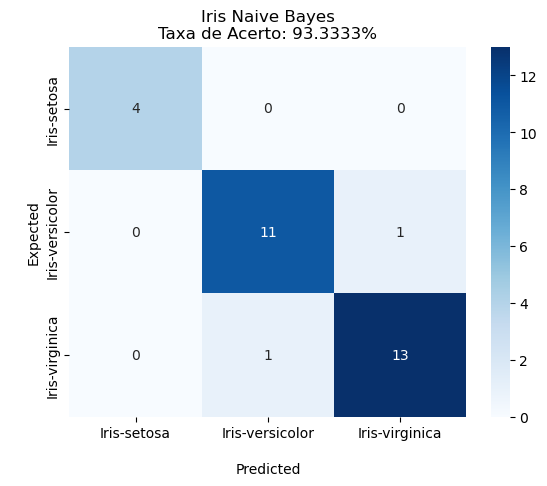

In [17]:
#Generating Confusion Matrix for the realization which it's accuracy is the most similar to the mean
ax = sns.heatmap(all_cfmats[closest_index], annot=True,cmap='Blues',fmt="d")
ax.set_title(f'Iris Naive Bayes\nTaxa de Acerto: {round(data_accuracy,6)*100}%');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('\nExpected');
ax.xaxis.set_ticklabels(np.unique(y))
ax.yaxis.set_ticklabels(np.unique(y))
plt.show()

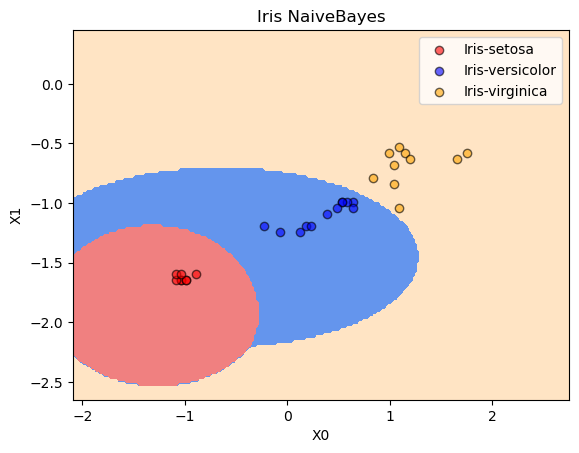

In [18]:
naivebayes_2C = NaiveBayes()
naivebayes_2C.train(all_x_train[-1][:,[2,3]],all_y_train[-1])
make_plot(naivebayes_2C,'Iris NaiveBayes',all_x_test[-1][:,[2,3]],all_y_test[-1], np.unique(all_y_test[-1]))

## A.3) Aumentando o Conjunto

In [19]:
print(f'X -> {X.shape}, y -> {y.shape}')
X_sampled, y_sampled = augment_dataset(X.copy(), y.copy())

X -> (150, 4), y -> (150,)


n_samples = 900
Classe = Iris-setosa, Iris-setosa_samples = 300
Classe = Iris-versicolor, Iris-versicolor_samples = 300
Classe = Iris-virginica, Iris-virginica_samples = 300


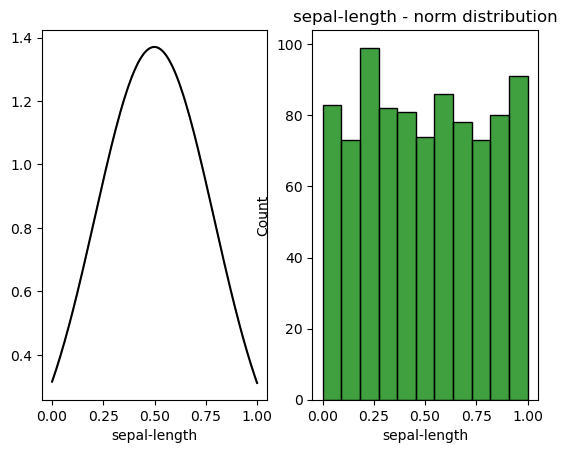

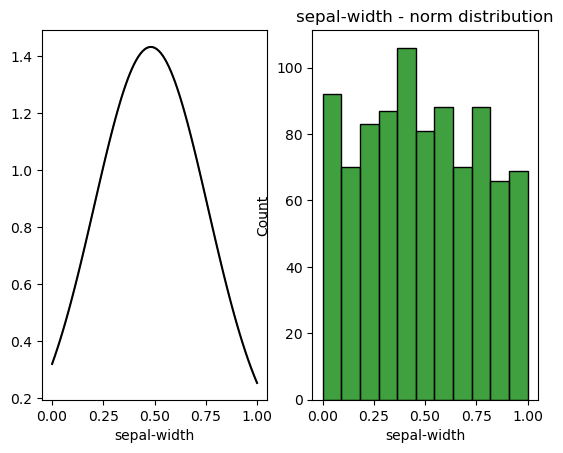

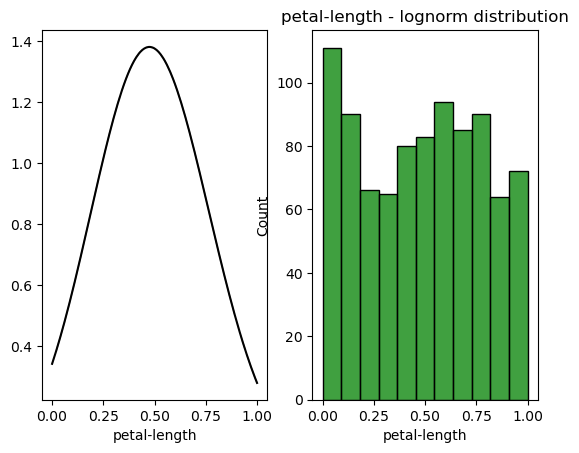

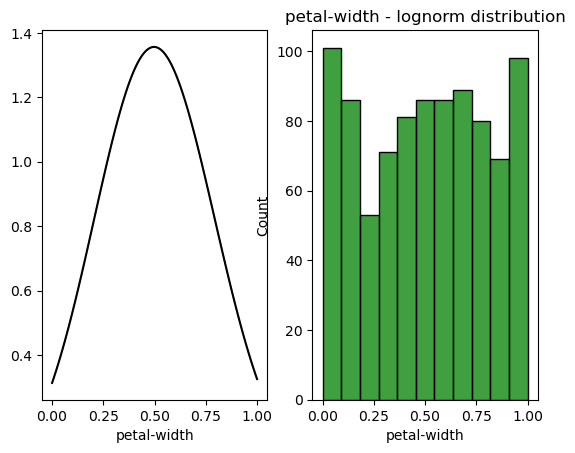

In [20]:
print(f'n_samples = {X_sampled.shape[0]}')
for y_ in np.unique(y_sampled):    
    print(f'Classe = {y_}, {y_}_samples = {len(X_sampled[y_sampled == y_])}')
for i in range(len(iris_dists)):
    histograma_distribuicao(X_sampled[iris_name[i]], iris_dists_names[i],iris_name[i], iris_dists[i])

# Parte B

# Removendo

In [21]:
def remover(X, n, valor='-'):
    X_ = X.copy()
    columns = X_.columns
    for i in range(n):
        x_i = np.random.randint(0, X_.index.size - 1)
        a_i = np.random.randint(0, X_.columns.size - 1)      
        while X_.loc[x_i, columns[a_i]] == valor:
            x_i = np.random.randint(0, X_.index.size - 1)
            a_i = np.random.randint(0, X_.columns.size - 1)
        X_.loc[x_i, columns[a_i]] = valor
    return X_
    
def calculate_RMSE(valores):
    return np.sqrt(np.square(valores).mean())

In [22]:
removido = remover(X,180)
removido_copia = removido.copy()
display(removido_copia)

,sepal-length,sepal-width,petal-length,petal-width
0,-,0.625,0.067797,0.041667
1,-,-,-,0.041667
2,0.111111,0.5,0.050847,0.041667
3,0.083333,-,-,0.041667
4,-,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,-,0.916667
146,-,-,-,0.750000
147,-,0.416667,-,0.791667
148,0.527778,-,0.745763,0.916667


## Valor Esperado

In [23]:
for feat, distribution in zip(removido_copia.columns, iris_dists):
    valores = removido_copia[removido_copia[feat] != '-'][feat].to_list()
    distr_params = distribution.fit(valores)
    distr = distribution(*distr_params)
    removido_copia[feat] = removido_copia[feat].replace('-', distr.expect())
print('\nRMSE:', calculate_RMSE(np.subtract(X.values, removido_copia.values)))
display(removido_copia)


RMSE: 0.13930335778625857


,sepal-length,sepal-width,petal-length,petal-width
0,0.416667,0.625000,0.067797,0.041667
1,0.416667,0.453804,0.456403,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.453804,0.456403,0.041667
4,0.416667,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.456403,0.916667
146,0.416667,0.453804,0.456403,0.750000
147,0.416667,0.416667,0.456403,0.791667
148,0.527778,0.453804,0.745763,0.916667


## KNN

In [24]:
removido_copia = removido.copy().replace('-', np.nan)
imputer = KNNImputer(n_neighbors=9)
removido_copia = pd.DataFrame(imputer.fit_transform(removido_copia), columns=removido_copia.columns)
print('\nRMSE:', calculate_RMSE(np.subtract(X.values, removido_copia.values)))
display(removido_copia)


RMSE: 0.06851178311164106


,sepal-length,sepal-width,petal-length,petal-width
0,0.200617,0.625000,0.067797,0.041667
1,0.175926,0.615741,0.079096,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.587963,0.077213,0.041667
4,0.191358,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.760829,0.916667
146,0.493827,0.351852,0.741996,0.750000
147,0.611111,0.416667,0.789077,0.791667
148,0.527778,0.467593,0.745763,0.916667
